In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.optim import Adam, AdamW, SGD
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau
from sklearn.decomposition import PCA
from tqdm import tqdm
from torchvision.models import vgg16, resnet50
import torchvision.transforms as transforms
import pickle
import os
from PIL import Image

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
training_data = []
test_data = unpickle('cifar-10-batches-py/test_batch')
for i in range(1, 6):
    batch = unpickle(f'cifar-10-batches-py/data_batch_{i}')
    training_data.append(batch)

print(len(training_data))

5


In [5]:
train_images = []
train_labels = []

for batch in training_data:
    train_images.append(batch[b'data'])
    train_labels.extend(batch[b'labels'])

train_images = np.vstack(train_images)  # Stack vertically to combine all batches
train_labels = np.array(train_labels)

# Extract test data
test_images = test_data[b'data']
test_labels = np.array(test_data[b'labels'])

# Print shapes
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training images shape: (50000, 3072)
Training labels shape: (50000,)
Test images shape: (10000, 3072)
Test labels shape: (10000,)


In [6]:
# 1. Raw uint8 version for visualization
raw_train_images = train_images.copy()
raw_test_images  = test_images.copy()

# 2. Reshape raw arrays
raw_train_images = raw_train_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
raw_test_images  = raw_test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# 3. Normalized version for training
train_images = raw_train_images.astype('float32') / 255.0
test_images  = raw_test_images.astype('float32') / 255.0

print("Pixel range (normalized):", train_images.min(), train_images.max())


Pixel range (normalized): 0.0 1.0


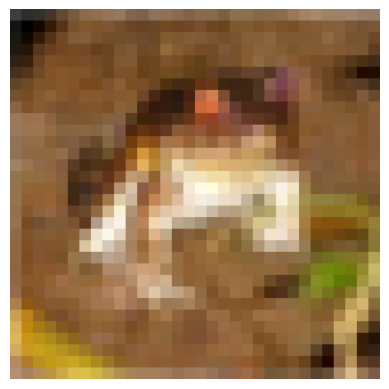

In [7]:
import cv2

img = raw_train_images[0]
bigger = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)

plt.imshow(bigger)
plt.axis('off')
plt.show()


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_model = vgg16(weights='IMAGENET1K_V1')
vgg16_model = vgg16_model.to(device)


In [9]:
#Freeze all the layers and use the model only as a feature extractor on the given datase
for param in vgg16_model.parameters():
    param.requires_grad = False

In [10]:
class ImageArrayDataset(TensorDataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = (self.images[idx]*255).astype('uint8')
        img_pil = Image.fromarray(img)
        if self.transform:
            img_pil = self.transform(img_pil)
        return img_pil

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

In [12]:
BATCH_SIZE = 64

In [13]:
def get_dataloader(images, transform, batch_size=BATCH_SIZE):
    dataset = ImageArrayDataset(images, transform=transform)
    return DataLoader(dataset,batch_size=batch_size,shuffle=False,num_workers=4,pin_memory=True,prefetch_factor=2,persistent_workers=True)

In [14]:
def extract_features(model, dataloader, device):
    model.eval()
    features_list = []
    model.to(device)
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device, non_blocking=True)
            feats = model.features(batch)
            feats = nn.functional.adaptive_avg_pool2d(feats, (2, 2))
            feats = feats.view(feats.size(0), -1)
            features_list.append(feats.cpu().numpy())

    return np.vstack(features_list)

In [15]:
train_loader = get_dataloader(train_images, train_transform, batch_size=BATCH_SIZE)
test_loader = get_dataloader(test_images, train_transform, batch_size=BATCH_SIZE)

features_train = extract_features(vgg16_model, train_loader, device)
features_test = extract_features(vgg16_model, test_loader, device)

print(f"Extracted training features: {features_train.shape}")
print(f"Extracted test features: {features_test.shape}")

Extracted training features: (50000, 2048)
Extracted test features: (10000, 2048)


## b.

In [16]:
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes, dropout):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)
        self.dropout = nn.Dropout(dropout)  # Dropout layer
    def forward(self, x):
        x = self.dropout(x)  # Apply dropout
        return self.fc(x)

In [17]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [18]:
classifier = Classifier(input_size=features_train.shape[1], num_classes=10, dropout=0.5)
classifier = classifier.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(classifier.parameters(), lr=0.001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
BATCH_SIZE = 128
EPOCHS = 30

In [19]:
X_train, X_val, y_train, y_val = train_test_split(features_train, train_labels, test_size=0.2, random_state=42)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

test_dataset = TensorDataset(torch.tensor(features_test, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [20]:
def trainer(model, train_loader, val_loader, criterion, optimizer, scheduler, device, patience, num_epochs):
    
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):

        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1) # We get two outputs: max values and their indices
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100.0 * correct / total

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item() * x.size(0)

                _, p = out.max(1)
                val_correct += p.eq(y).sum().item()
                val_total += y.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = 100.0 * val_correct / val_total

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_vgg16_model.pth")
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping triggered.")
                break
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# train_losses, val_losses, train_accuracies, val_accuracies = trainer(classifier,train_loader,val_loader,criterion,optimizer,scheduler,device,5,num_epochs=EPOCHS)

Epoch 1/30:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/30: 100%|██████████| 313/313 [00:01<00:00, 212.13it/s]


Epoch 1/30 | Train Loss: 0.8131 | Val Loss: 0.5661 | Train Acc: 75.41% | Val Acc: 83.25%


Epoch 2/30: 100%|██████████| 313/313 [00:01<00:00, 243.04it/s]


Epoch 2/30 | Train Loss: 0.5902 | Val Loss: 0.5170 | Train Acc: 81.03% | Val Acc: 84.47%


Epoch 3/30: 100%|██████████| 313/313 [00:01<00:00, 235.29it/s]


Epoch 3/30 | Train Loss: 0.5685 | Val Loss: 0.5066 | Train Acc: 81.49% | Val Acc: 84.49%


Epoch 4/30: 100%|██████████| 313/313 [00:01<00:00, 251.98it/s]


Epoch 4/30 | Train Loss: 0.5648 | Val Loss: 0.5068 | Train Acc: 81.53% | Val Acc: 84.21%


Epoch 5/30: 100%|██████████| 313/313 [00:01<00:00, 245.04it/s]


Epoch 5/30 | Train Loss: 0.5592 | Val Loss: 0.5059 | Train Acc: 81.86% | Val Acc: 84.37%


Epoch 6/30: 100%|██████████| 313/313 [00:01<00:00, 246.65it/s]


Epoch 6/30 | Train Loss: 0.5594 | Val Loss: 0.5058 | Train Acc: 81.85% | Val Acc: 84.18%


Epoch 7/30: 100%|██████████| 313/313 [00:01<00:00, 244.21it/s]


Epoch 7/30 | Train Loss: 0.5627 | Val Loss: 0.5034 | Train Acc: 81.66% | Val Acc: 84.57%


Epoch 8/30: 100%|██████████| 313/313 [00:01<00:00, 226.33it/s]


Epoch 8/30 | Train Loss: 0.5584 | Val Loss: 0.5041 | Train Acc: 82.09% | Val Acc: 84.58%


Epoch 9/30: 100%|██████████| 313/313 [00:01<00:00, 247.61it/s]


Epoch 9/30 | Train Loss: 0.5589 | Val Loss: 0.4999 | Train Acc: 81.87% | Val Acc: 84.73%


Epoch 10/30: 100%|██████████| 313/313 [00:01<00:00, 243.76it/s]


Epoch 10/30 | Train Loss: 0.5615 | Val Loss: 0.5015 | Train Acc: 81.74% | Val Acc: 84.53%


Epoch 11/30: 100%|██████████| 313/313 [00:01<00:00, 245.40it/s]


Epoch 11/30 | Train Loss: 0.5563 | Val Loss: 0.5012 | Train Acc: 82.02% | Val Acc: 84.65%


Epoch 12/30: 100%|██████████| 313/313 [00:01<00:00, 241.36it/s]


Epoch 12/30 | Train Loss: 0.5603 | Val Loss: 0.5039 | Train Acc: 81.83% | Val Acc: 84.30%
Early stopping triggered.


In [21]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', marker ='o', linestyle='--', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', marker ='s', linestyle='--', color='orange', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

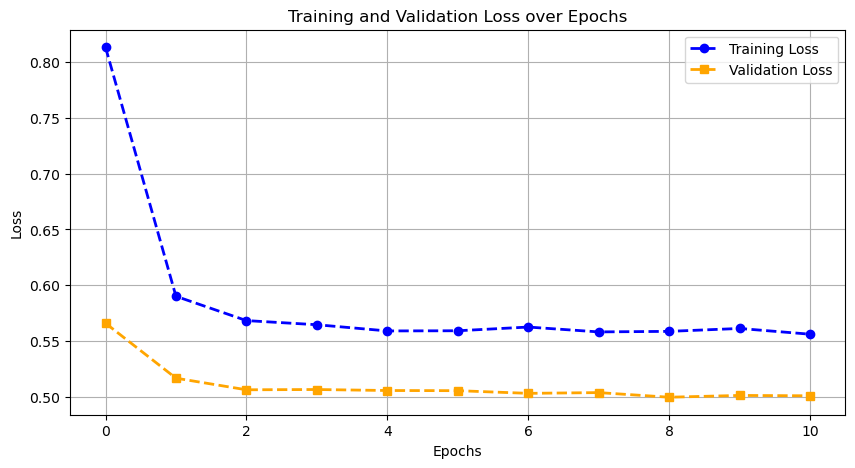

In [22]:
plot_loss(train_losses, val_losses)

In [22]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', marker ='o')
    plt.plot(val_accuracies, label='Validation Accuracy', marker ='x')
    plt.xlabel('Epochs')
    plt.grid(True)
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.show()

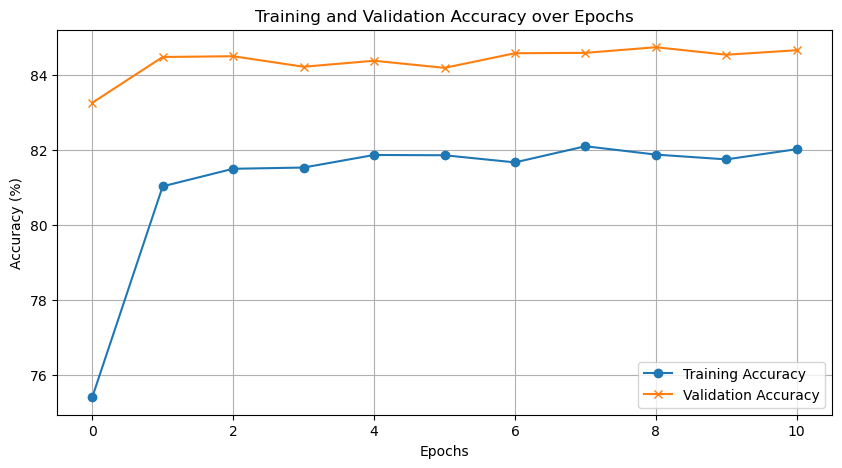

In [24]:
plot_accuracy(train_accuracies, val_accuracies)

In [23]:
def compute_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


In [24]:
classifier.load_state_dict(torch.load("best_model.pth")) # Load the best model
print(f"Accuracy on test data: {compute_accuracy(classifier, test_loader, device)} %")

Accuracy on test data: 84.16 %


In [25]:
#Classwise accuracy
def classwise_accuracy(model, test_loader, device):
    model.eval()
    class_correct = [0] * 10
    class_total = [0] * 10
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
                label = labels[i]
                class_total[label] += 1
                if predicted[i] == label:
                    class_correct[label] += 1
    class_accuracies = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(10)]
    return class_accuracies

In [26]:
# classwise_accuracy(classifier, test_loader, device)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
accuracies = classwise_accuracy(classifier, test_loader, device)
for i, acc in enumerate(accuracies):
    print(f"Accuracy for class {class_names[i]}: {acc:.2f}%")

Accuracy for class airplane: 87.60%
Accuracy for class automobile: 93.60%
Accuracy for class bird: 77.20%
Accuracy for class cat: 70.90%
Accuracy for class deer: 77.80%
Accuracy for class dog: 82.60%
Accuracy for class frog: 88.20%
Accuracy for class horse: 84.60%
Accuracy for class ship: 88.70%
Accuracy for class truck: 90.40%


# Q2 Domain Shift Evaluation and Fine-Tuning:

In [27]:
cifar_dir = "CIFAR-10-C/brightness.npy"


In [ ]:
corruption_dir = "CIFAR-10-C"
corruption_types = sorted([
    f.replace(".npy", "")
    for f in os.listdir(corruption_dir)
    if f.endswith(".npy") and f != "labels.npy"
])

labels = np.load(os.path.join(corruption_dir, "labels.npy"))

In [29]:
#Sample 10000 data points from cifar-10 c and check the accuracy
idx = np.random.choice(len(labels), size=10000, replace=False)
results = {}
for corruption in corruption_types:
    corrupted_images = np.load(os.path.join(corruption_dir, f"{corruption}.npy"))
    corrupted_images = corrupted_images[idx]
    corrupted_images = corrupted_images.astype('float32') / 255.0

    corrupted_loader = get_dataloader(corrupted_images, train_transform, batch_size=BATCH_SIZE)
    corrupted_features = extract_features(vgg16_model, corrupted_loader, device)

    corrupted_dataset = TensorDataset(torch.tensor(corrupted_features, dtype=torch.float32), torch.tensor(labels[idx], dtype=torch.long))
    corrupted_loader_final = DataLoader(corrupted_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    acc = compute_accuracy(classifier, corrupted_loader_final, device)
    results[corruption] = acc
    print(f"Accuracy on {corruption} corruption: {acc:.2f}%")

Accuracy on brightness corruption: 81.61%
Accuracy on contrast corruption: 67.85%
Accuracy on defocus_blur corruption: 70.88%
Accuracy on elastic_transform corruption: 66.41%
Accuracy on fog corruption: 72.89%
Accuracy on frost corruption: 69.37%
Accuracy on gaussian_blur corruption: 65.94%
Accuracy on gaussian_noise corruption: 30.01%
Accuracy on glass_blur corruption: 47.86%
Accuracy on impulse_noise corruption: 27.04%
Accuracy on jpeg_compression corruption: 68.69%
Accuracy on motion_blur corruption: 61.91%
Accuracy on pixelate corruption: 59.98%
Accuracy on saturate corruption: 77.78%
Accuracy on shot_noise corruption: 39.77%
Accuracy on snow corruption: 70.58%
Accuracy on spatter corruption: 70.07%
Accuracy on speckle_noise corruption: 43.24%
Accuracy on zoom_blur corruption: 67.18%


In [30]:
class ImageLabelDataset(torch.utils.data.Dataset):
	def __init__(self, images, labels, transform=None):
		self.images = images
		self.labels = labels
		self.transform = transform

	def __len__(self):
		return len(self.images)

	def __getitem__(self, idx):
		img = (self.images[idx]*255).astype('uint8')
		img_pil = Image.fromarray(img)
		if self.transform:
			img_pil = self.transform(img_pil)
		label = torch.tensor(self.labels[idx], dtype=torch.long)
		return img_pil, label

In [31]:
vgg_model2 = vgg16(weights='IMAGENET1K_V1')
vgg_model2 = vgg_model2.to(device)
for param in vgg_model2.parameters():
    param.requires_grad = False
#Unfreeze last conv block and train the model 
for param in vgg_model2.features[24:].parameters(): # There are total 31 layers in features. Adding from 24 to 31 means unfreezing last conv block
    param.requires_grad = True
for param in vgg_model2.classifier.parameters():
    param.requires_grad = True

In [32]:
criterion_finetune = nn.CrossEntropyLoss()
optimizer_finetune = Adam(filter(lambda p: p.requires_grad, vgg_model2.parameters()), lr=0.0001, weight_decay=0.01)
scheduler_finetune = ReduceLROnPlateau(optimizer_finetune, mode='min', factor=0.5, patience=5)
BATCH_SIZE = 64
EPOCHS = 30

In [33]:
np.random.seed(42)
sampled_idx = np.random.choice(len(train_images), size=10000, replace=False)
sampled_images = train_images[sampled_idx]
sampled_labels = train_labels[sampled_idx]
X_train, X_val, y_train, y_val = train_test_split(sampled_images, sampled_labels, test_size=0.2, random_state=42)
train_dataset_finetune = ImageLabelDataset(X_train, y_train, transform=train_transform)
val_dataset_finetune = ImageLabelDataset(X_val, y_val, transform=train_transform)
train_loader = DataLoader(train_dataset_finetune, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset_finetune, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
# train_losses, val_losses, train_accuracies, val_accuracies = trainer(vgg_model2,train_loader,val_loader,criterion_finetune,optimizer_finetune,scheduler_finetune,device,5,num_epochs=EPOCHS)

Epoch 1/30: 100%|██████████| 125/125 [00:11<00:00, 10.58it/s]


Epoch 1/30 | Train Loss: 1.2578 | Val Loss: 0.5376 | Train Acc: 66.26% | Val Acc: 81.15%


Epoch 2/30: 100%|██████████| 125/125 [00:11<00:00, 10.50it/s]


Epoch 2/30 | Train Loss: 0.3708 | Val Loss: 0.6233 | Train Acc: 87.39% | Val Acc: 80.05%


Epoch 3/30: 100%|██████████| 125/125 [00:11<00:00, 10.45it/s]


Epoch 3/30 | Train Loss: 0.1906 | Val Loss: 0.4760 | Train Acc: 93.60% | Val Acc: 84.65%


Epoch 4/30: 100%|██████████| 125/125 [00:11<00:00, 10.44it/s]


Epoch 4/30 | Train Loss: 0.1359 | Val Loss: 0.5953 | Train Acc: 95.40% | Val Acc: 81.10%


Epoch 5/30: 100%|██████████| 125/125 [00:11<00:00, 10.46it/s]


Epoch 5/30 | Train Loss: 0.1046 | Val Loss: 0.5293 | Train Acc: 96.69% | Val Acc: 84.65%


Epoch 6/30: 100%|██████████| 125/125 [00:12<00:00, 10.39it/s]


Epoch 6/30 | Train Loss: 0.1150 | Val Loss: 0.5556 | Train Acc: 96.08% | Val Acc: 82.80%


Epoch 7/30: 100%|██████████| 125/125 [00:12<00:00, 10.37it/s]


Epoch 7/30 | Train Loss: 0.1203 | Val Loss: 0.6020 | Train Acc: 96.00% | Val Acc: 83.30%
Early stopping triggered.


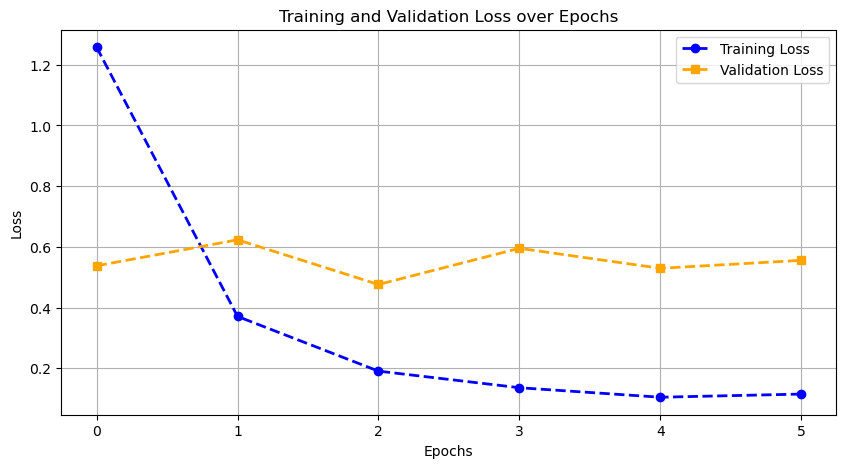

In [81]:
plot_loss(train_losses, val_losses)

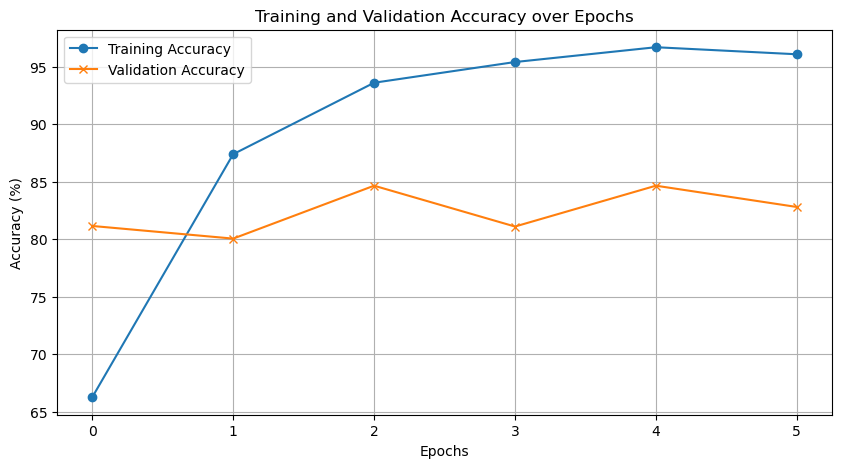

In [82]:
plot_accuracy(train_accuracies, val_accuracies)

In [34]:
#Sample for testing
np.random.seed(42)
sampled_idx = np.random.choice(len(train_images), size=10000, replace=False)
sampled_test_images = train_images[sampled_idx]
sampled_test_labels = train_labels[sampled_idx]
sampled_test_dataset = ImageLabelDataset(sampled_test_images, sampled_test_labels, transform=train_transform)
sampled_test_loader = DataLoader(sampled_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [35]:
vgg_model2.load_state_dict(torch.load("best_vgg16_model.pth"))

<All keys matched successfully>

In [36]:
print(f"Accuracy on sampled test data: {compute_accuracy(vgg_model2, sampled_test_loader, device)} %")

Accuracy on sampled test data: 95.64 %


# Q3.  Feature Representation Analysis

In [43]:
# Extract features from the penultimate layer of the finetuned VGG16 model
import torch.nn.functional as F
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = model.features
        self.avgpool = model.avgpool
        self.classifier = nn.Sequential(*list(model.classifier.children())[:-1])  # Exclude the last layer

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [45]:
cifar10_vgg_extractor1 = FeatureExtractor(vgg16_model)
cifar10_vgg_extractor2 = FeatureExtractor(vgg_model2)
cifar10_vgg_extractor1 = cifar10_vgg_extractor1.to(device)
cifar10_vgg_extractor2 = cifar10_vgg_extractor2.to(device)

In [46]:
# Extract features from the finetuned model for CIFAR-10-C evaluation
def extract_features_penultimate(model, dataloader, device):
    model.eval()
    features_list = []
    model.to(device)
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device, non_blocking=True)
            feats = model(batch)
            features_list.append(feats.cpu().numpy())

    return np.vstack(features_list)

In [47]:
# Get entire cifar-10-c dataset
training_data_c = []
for corruption in corruption_types:
    corrupted_images = np.load(os.path.join(corruption_dir, f"{corruption}.npy"))
    corrupted_images = corrupted_images.astype('float32') / 255.0
    training_data_c.append(corrupted_images)
training_data_c = np.vstack(training_data_c)

In [49]:
print(f"cifar-10-c shape: {training_data_c.shape}")

cifar-10-c shape: (950000, 32, 32, 3)


In [77]:
cifar_c_dataset = ImageArrayDataset(training_data_c, transform=train_transform)
cifar_c_loader = DataLoader(cifar_c_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
features_from_finetuned = extract_features_penultimate(cifar10_vgg_extractor2, cifar_c_loader, device)
features_from_pretrained = extract_features_penultimate(cifar10_vgg_extractor1, cifar_c_loader, device)

In [78]:
def pca_analysis(features1, features2, labels, n_components=2, title = None):
    pca = PCA(n_components=n_components)
    
    reduced1 = pca.fit_transform(features1)
    reduced2 = pca.transform(features2)
    
    exp = pca.explained_variance_ratio_
    
    plt.figure(figsize=(14, 6))
    
    # Clean features
    plt.subplot(1, 2, 1)
    plt.scatter(reduced1[:,0], reduced1[:,1], c=labels, cmap='tab10', alpha=0.5)
    plt.title(f"PCA Using pretrained model" + title + "\n" + f" (EV={exp.sum():.2f})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    
    # Corrupted features
    plt.subplot(1, 2, 2)
    plt.scatter(reduced2[:,0], reduced2[:,1], c=labels, cmap='tab10', alpha=0.5)
    plt.title(f"PCA Using Finetuned model" + title + "\n" + f" (EV={exp.sum():.2f})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


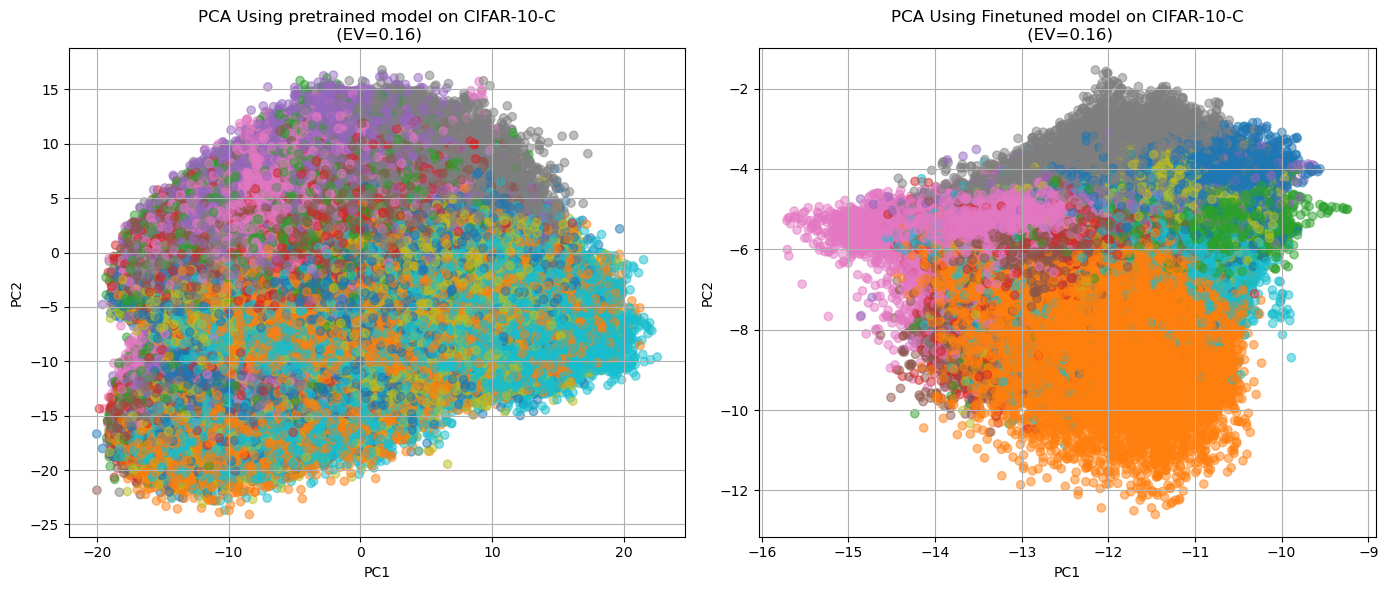

In [79]:
# Create extended labels for all corruptions
extended_labels = np.tile(labels, len(corruption_types))
pca_analysis(features_from_pretrained, features_from_finetuned, extended_labels, title=" on CIFAR-10-C")

In [74]:
train_loader_clean = get_dataloader(train_images, train_transform, batch_size=BATCH_SIZE)
features_from_pretrained_clean = extract_features_penultimate(cifar10_vgg_extractor1, train_loader_clean, device)
features_from_finetuned_clean = extract_features_penultimate(cifar10_vgg_extractor2, train_loader_clean, device)

In [75]:
print(f"Features from pretrained model shape: {features_from_pretrained_clean.shape}")
print(f"Features from finetuned model shape: {features_from_finetuned_clean.shape}")

Features from pretrained model shape: (50000, 4096)
Features from finetuned model shape: (50000, 4096)


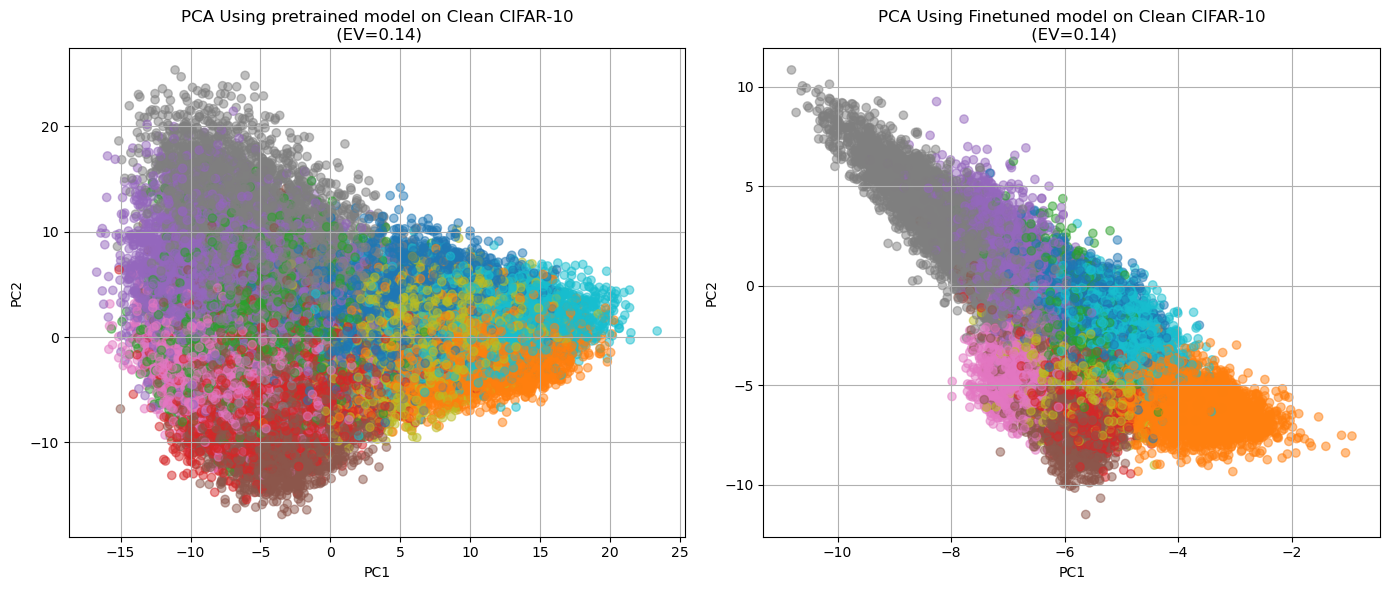

In [76]:
pca_analysis(features_from_pretrained, features_from_finetuned, train_labels, title=" on Clean CIFAR-10")